# 1 - download and get the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d nageshsingh/dna-sequence-dataset/code

  0% 0.00/1.51M [00:00<?, ?B/s]
100% 1.51M/1.51M [00:00<00:00, 144MB/s]


In [6]:
!unzip /content/dna-sequence-dataset.zip

Archive:  /content/dna-sequence-dataset.zip
  inflating: chimpanzee.txt          
  inflating: dog.txt                 
  inflating: example_dna.fa          
  inflating: human.txt               


# 2 - explore and prepare data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [8]:
human_data = pd.read_table('/content/human.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [9]:
#We have some data for human DNA sequence coding regions and a class label.
# We also have data for Chimpanzee and a more divergent species, the dog.

In [10]:
chimp_data = pd.read_table('/content/chimpanzee.txt')
dog_data = pd.read_table('/content/dog.txt')
chimp_data.head()
dog_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


In [17]:
print(human_data['class'].value_counts())

6    1343
4     711
3     672
1     534
0     531
2     349
5     240
Name: class, dtype: int64


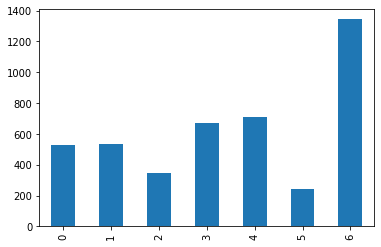

In [35]:
#If we have a look at class balance we can see we have relatively balanced dataset.
human_data['class'].value_counts().sort_index().plot.bar()

In [18]:
# class 0 indicates to g protein coupled receptors
# class 1 indicates to tyrosin kinase
# class 2 indicates to tyrosin phosphate
# class 3 indicates to synthetase
# class 4 indicates to synthase
# class 5 indicates to ion channel
# class 6 indicates to transcription factor

In [20]:
#Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. 
#We will basically apply the k-mers to the complete sequences.
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [21]:
#Now we can convert our training data sequences into short overlapping k-mers of legth 6.
#Lets do that for each species of data we have using our getKmers function.
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)
chimp_data['words'] = chimp_data.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp_data = chimp_data.drop('sequence', axis=1)
dog_data['words'] = dog_data.apply(lambda x: getKmers(x['sequence']), axis=1)
dog_data = dog_data.drop('sequence', axis=1)

In [24]:
#Now, our coding sequence data is changed to lowercase,
#split up into all possible k-mer words of length 6 and ready for the next step. Let's take a look.
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [25]:
#Since we are going to use scikit-learn natural language processing tools to do the k-mer counting,
#we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.
#We can also make a y variable to hold the class labels. Let's do that now.

In [26]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values  

In [31]:
print(human_texts[0:1])

['atgccc tgcccc gcccca ccccaa cccaac ccaact caacta aactaa actaaa ctaaat taaata aaatac aatact atacta tactac actacc ctaccg taccgt accgta ccgtat cgtatg gtatgg tatggc atggcc tggccc ggccca gcccac cccacc ccacca caccat accata ccataa cataat ataatt taatta aattac attacc ttaccc tacccc accccc ccccca ccccat cccata ccatac catact atactc tactcc actcct ctcctt tcctta ccttac cttaca ttacac tacact acacta cactat actatt ctattc tattcc attcct ttcctc tcctca cctcat ctcatc tcatca catcac atcacc tcaccc caccca acccaa cccaac ccaact caacta aactaa actaaa ctaaaa taaaaa aaaaat aaaata aaatat aatatt atatta tattaa attaaa ttaaac taaaca aaacac aacaca acacaa cacaaa acaaac caaact aaacta aactac actacc ctacca taccac accacc ccacct caccta acctac cctacc ctacct tacctc acctcc cctccc ctccct tccctc ccctca cctcac ctcacc tcacca caccaa accaaa ccaaag caaagc aaagcc aagccc agccca gcccat cccata ccataa cataaa ataaaa taaaaa aaaaat aaaata aaataa aataaa ataaaa taaaaa aaaaaa aaaaat aaaatt aaatta aattat attata ttataa tataac ataaca taacaa aacaaa acaa

In [32]:
#We will perform the same steps for chimpanzee and dog
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_chimp = chimp_data.iloc[:, 0].values                       # y_c for chimp

dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_dog = dog_data.iloc[:, 0].values   

In [33]:
#Now we will apply the BAG of WORDS using CountVectorizer using NLP
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [34]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


# 3 - Creating model

In [36]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [37]:
### Multinomial Naive Bayes Classifier ###
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [38]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984
